# Offline hand-eye callibration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import json
import sys
import glob

from apriltag import apriltag

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../offline_hand_eye")))
from calib_io_utils import save_calibration, load_calibration
from calibration_utils import load_and_detect, show_detections, compute_hand_eye_calibration, frame_is_valid, compute_TCP_image_position

In [2]:
data_root = os.path.expanduser('~/data/cobot/realsense/calibration/calibdata_2025_08_11-11_51_22')
calibration_config_file = '../../../handeye_calibration_params.json'

with open(calibration_config_file, 'r') as f:
    calibration_config = json.load(f)

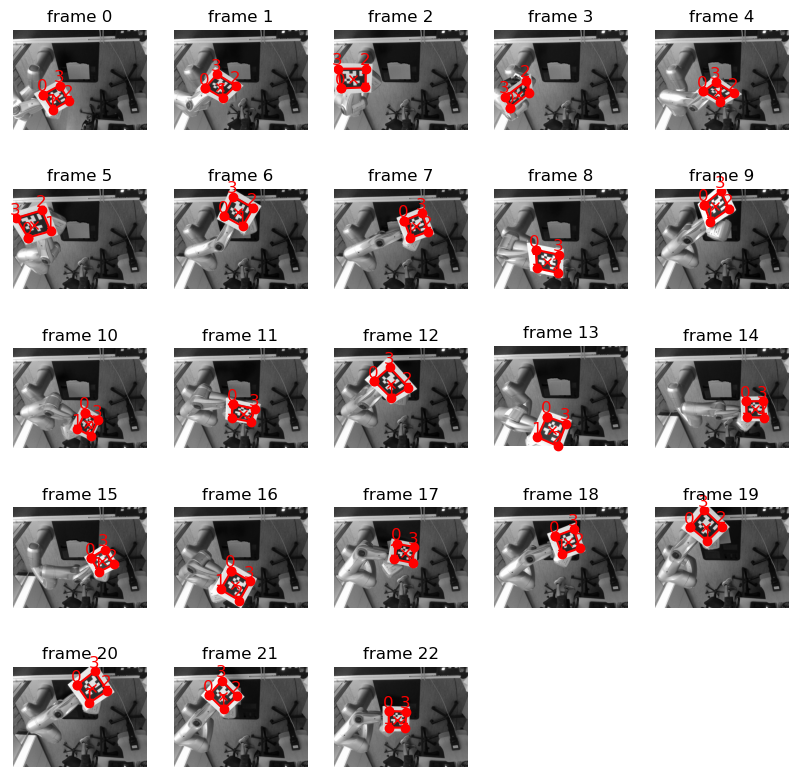

In [3]:
apriltag_family = 'tag36h11'
detector = apriltag(apriltag_family)

num_frames = len(glob.glob1(data_root, "frame_*.pkl"))
plt.figure(figsize=(10, 10))
for i, frame_count in enumerate(np.linspace(0, num_frames-1, min(num_frames, 25), dtype=int)): 
    frame, gray, detections = load_and_detect(frame_count, data_root, detector)

    plt.subplot(5, 5, i + 1)
    show_detections(gray, detections, apriltag_family, show_legend=False, show_family=False)
    plt.title('frame %d' % frame_count)

In [4]:
frame, gray, detections = load_and_detect(10, data_root, detector)
frame

{'image_timestamp': (1754913281, 881792236),
 'robot_transform': OrderedDict([('translation',
               OrderedDict([('x', 0.5927182330326759),
                            ('y', 0.9605102301348581),
                            ('z', 0.017515726128091158)])),
              ('rotation',
               OrderedDict([('x', 0.848245601608102),
                            ('y', 0.21850021141091713),
                            ('z', -0.4217332821607434),
                            ('w', 0.23426074294217644)]))]),
 'tracking_transform': None,
 'camera_info': OrderedDict([('header',
               OrderedDict([('stamp',
                             OrderedDict([('sec', 1754913281),
                                          ('nanosec', 481502441)])),
                            ('frame_id', 'camera_color_optical_frame')])),
              ('height', 480),
              ('width', 640),
              ('distortion_model', 'plumb_bob'),
              ('d', [0.0, 0.0, 0.0, 0.0, 0.0]),
          

In [5]:
frame_samples = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

for frame_count in frame_samples:
    frame, gray, detections = load_and_detect(frame_count, data_root, detector)
    if not frame_is_valid(frame, detections):
        print(f"Error: Invalid frame {frame_count}")

In [6]:
tagsize = 0.14  # Size of the tag in meters
hand_camera_rot, hand_camera_tr, hand_camera_qwxyz = compute_hand_eye_calibration(data_root, frame_samples, detector, tagsize)

print("Hand-Eye Calibration Results:")
print("Rotation Matrix:")
print(hand_camera_rot)
print("Quaternion (wxyz):")
print(hand_camera_qwxyz)
print("Translation Vector:")
print(hand_camera_tr)

Hand-Eye Calibration Results:
Rotation Matrix:
[[-0.99009884  0.00133531  0.14036558]
 [ 0.0990719   0.71504503  0.69202266]
 [-0.09944365  0.69907712 -0.70809755]]
Quaternion (wxyz):
[0.06490115 0.02717386 0.92374799 0.37648249]
Translation Vector:
[[-0.62374302]
 [-0.46101668]
 [ 1.53653246]]


In [7]:
calibration_file = '../../../handeye_calibration.json'
if True:
    save_calibration(calibration_file, calibration_config, hand_camera_qwxyz.tolist(), hand_camera_tr.tolist(), 
                     frame_samples, data_root)

    loaded_calibration = load_calibration(calibration_file)
    print("Loaded Calibration:")
    print(loaded_calibration)   

Loaded Calibration:
{'calibration_type': 'eye_on_base', 'robot_base_frame': 'base_link', 'robot_effector_frame': 'TCP', 'tracking_base_frame': 'camera_color_optical_frame', 'translation': [[-0.6237430185373503], [-0.4610166772884194], [1.5365324638530677]], 'rotation_q_wxyz': [0.06490115156444469, 0.027173861705176945, 0.9237479927265404, 0.37648249321757987], 'selected_samples': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], 'data_file_path': '/Users/thao/data/cobot/realsense/calibration/calibdata_2025_08_11-11_51_22'}


## Stability testing

In [12]:
for method in ['TSAI', 'PARK', 'HORAUD', 'ANDREFF', 'DANIILIDIS']:
    rmat, tr, _ = compute_hand_eye_calibration(data_root, frame_samples, detector, tagsize, method_str=method)
    rvec, _ = cv2.Rodrigues(rmat)
    print('method=%10s' % method, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())

method=      TSAI : rotation:  [0.0820124  2.78792875 1.13624752] , translation:  [-0.62374302 -0.46101668  1.53653246]
method=      PARK : rotation:  [0.09334685 2.78409104 1.18350202] , translation:  [-0.6224394  -0.46306211  1.52578536]
method=    HORAUD : rotation:  [0.09511113 2.78346837 1.18378895] , translation:  [-0.62271287 -0.46314145  1.52550684]
method=   ANDREFF : rotation:  [0.09868133 2.7836248  1.18644198] , translation:  [-0.58581731 -0.37545491  1.45579167]
method=DANIILIDIS : rotation:  [0.08792085 2.7957513  1.15043818] , translation:  [-0.61404766 -0.44734601  1.5384945 ]


In [8]:
samples = frame_samples
for i in range(5):
    rmat, tr, _ = compute_hand_eye_calibration(data_root, samples, detector, tagsize)
    rvec, _ = cv2.Rodrigues(rmat)
    print('permutation=%02d' % i, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())
    samples = np.random.permutation(frame_samples)

permutation=00 : rotation:  [0.0820124  2.78792875 1.13624752] , translation:  [-0.62374302 -0.46101668  1.53653246]
permutation=01 : rotation:  [0.0820124  2.78792875 1.13624752] , translation:  [-0.62495318 -0.46094592  1.53820246]
permutation=02 : rotation:  [0.0820124  2.78792875 1.13624752] , translation:  [-0.62556082 -0.46093793  1.53676439]
permutation=03 : rotation:  [0.0820124  2.78792875 1.13624752] , translation:  [-0.62404702 -0.46196256  1.53624603]
permutation=04 : rotation:  [0.0820124  2.78792875 1.13624752] , translation:  [-0.62401236 -0.46191666  1.53620561]


In [9]:
samples = np.random.permutation(frame_samples)
for i in range(5, len(samples)+1):
    rmat, tr, _ = compute_hand_eye_calibration(data_root, samples[:i], detector, tagsize)
    rvec, _ = cv2.Rodrigues(rmat)
    print('len=%02d' % i, ': rotation: ', rvec.flatten(), ', translation: ', tr.flatten())


len=05 : rotation:  [0.0405917  2.79460778 1.12326234] , translation:  [-0.60842927 -0.46275878  1.53909683]
len=06 : rotation:  [0.04024646 2.79368464 1.12612957] , translation:  [-0.61540955 -0.46049883  1.54161935]
len=07 : rotation:  [0.08121604 2.79242231 1.13076164] , translation:  [-0.61602867 -0.45411406  1.52499285]
len=08 : rotation:  [0.05747569 2.78988301 1.11087692] , translation:  [-0.61110358 -0.44651874  1.53147957]
len=09 : rotation:  [0.0583167  2.78904395 1.1122128 ] , translation:  [-0.61070735 -0.44747006  1.53226649]
len=10 : rotation:  [0.05621442 2.78677233 1.1090736 ] , translation:  [-0.61066567 -0.44334298  1.53233326]
len=11 : rotation:  [0.05901656 2.78719539 1.10669575] , translation:  [-0.60949595 -0.44155692  1.53016076]
len=12 : rotation:  [0.06210928 2.79096675 1.08742803] , translation:  [-0.61877112 -0.43571073  1.53724419]
len=13 : rotation:  [0.06155816 2.79057367 1.09157247] , translation:  [-0.61258074 -0.43377058  1.53374386]
len=14 : rotation: 

## Reprojection test

(array([[-0.50391569],
        [ 0.0367967 ],
        [ 0.77723424]]),
 array([323.75708222, 137.37586246]))

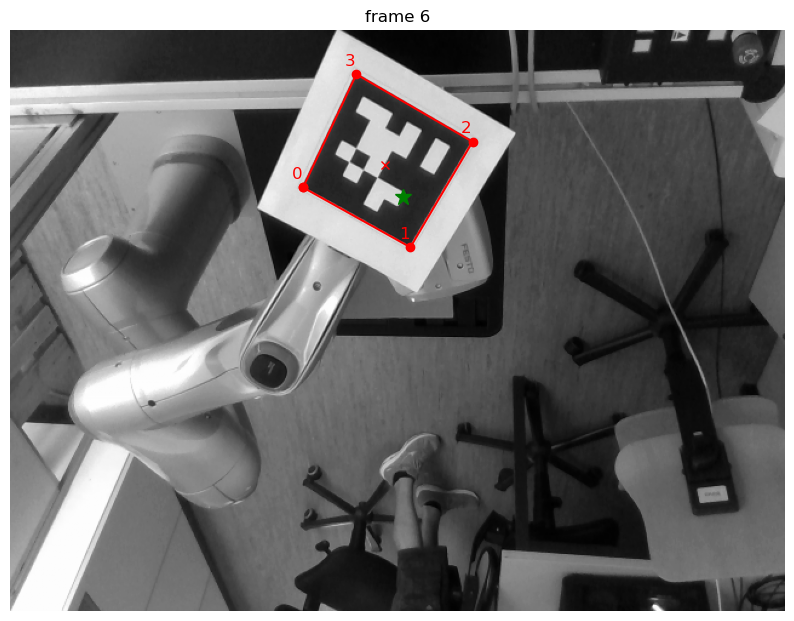

In [10]:
frame_count = 6

frame, gray, detections = load_and_detect(frame_count, data_root, detector)
assert frame_is_valid(frame, detections), f"Frame {frame_count} is invalid"

plt.figure(figsize=(10, 10))
show_detections(gray, detections, apriltag_family, show_legend=False, show_family=False)
plt.title('frame %d' % frame_count)

img_points, TCP_world = compute_TCP_image_position(frame, hand_camera_rot, hand_camera_tr)
plt.plot(img_points[0], img_points[1], 'g*', ms=12, label='TCP Projection')

TCP_world, img_points